# Chapter 15 Exercises

We will examine time series using https://fred.stlouisfed.org/series/TOTALNSA <br>

The dataset can be found at: https://raw.githubusercontent.com/tweyde/binder-test/main/data/TOTALNSA.csv

In [509]:
# Package to work with tubular data
import pandas as pd 

# Packages for charting
import matplotlib.pyplot as plt
import seaborn as sns #charts

# Package for timing runtime
import time

# Math...
import numpy as np
import math
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels as sm

## Exercise 1 <br>
Read the file TOTALNSA.csv. Decompose the series into trend, seasonality and noise. 

In [510]:
# read the csv file
df = pd.read_csv('https://raw.githubusercontent.com/tweyde/binder-test/main/data/TOTALNSA.csv', parse_dates = ['DATE'])
# display first 5 columns
df.head()

,DATE,TOTALNSA
0,1976-01-01,885.2
1,1976-02-01,994.7
2,1976-03-01,1243.6
3,1976-04-01,1191.2
4,1976-05-01,1203.2


In [511]:
# convert the date column to datetime type
pd.to_datetime(df.DATE)
# set the date as index (DatetimeIndex)
df = df.set_index('DATE')

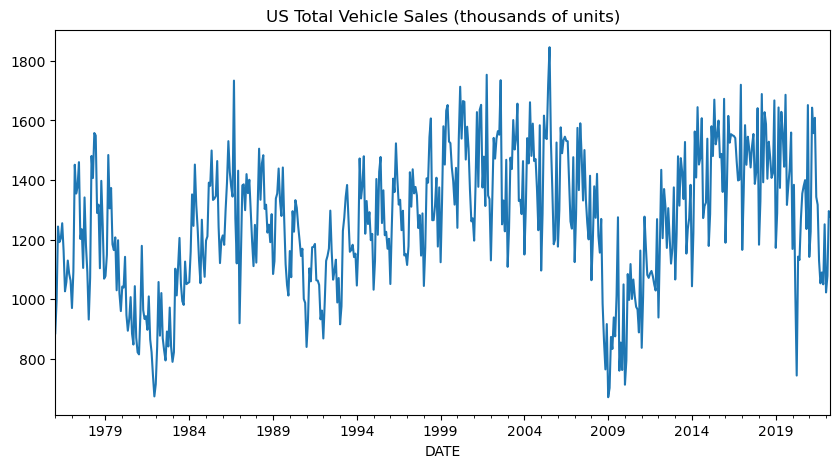

In [512]:
# plot the data 
plt.figure(figsize=(10, 5)) 
plt.title('US Total Vehicle Sales (thousands of units)') 
df['TOTALNSA'].plot();

Decompose the series into trend, seasonality and noise:

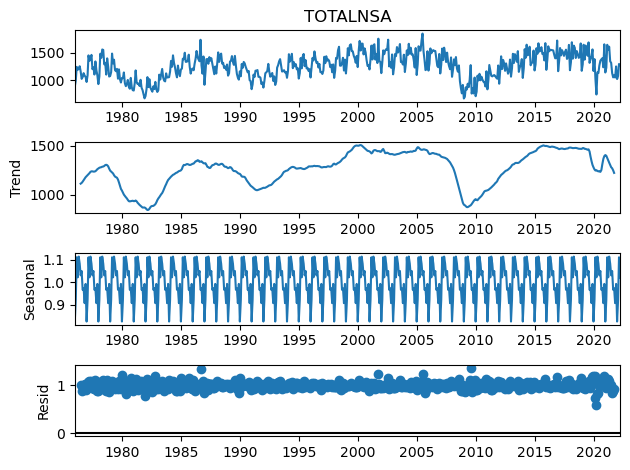

In [513]:
# decomposes the timeseries (top chart) into trend seasonality and noise (resid)
result = seasonal_decompose(df['TOTALNSA'], model='multiplicable', period = 12)
result.plot()
plt.show()

You can access the above values with:

In [514]:
# observed
result.observed
# trend
result.trend.dropna()
# seasonality
result.seasonal.dropna() 
# noise 
result.resid.dropna();

## Exercise 2 <br>
We want to know the trend growth in vehicle sales over the past 5 years, with seasonality removed. Use a MA to do this and calculate the average trend growth as a number. The timeseries is seasonal. Remove the seasonality from the timeseries using statsmodels seasonal_decompose function, to create a seasonality adjusted (SA) vehicle sales timeseries. Use linear extrapolation, using the statsmodel.interpolate function or similar to forecast, applied to SA vehicle sales, to forecast vehicle sales in 12months time.   

In [515]:
# get the last 6 years (we will take 6 years instead of 5 to avoid NaNs in the 5 year rolling mean)
df_last6years = df[-12*6:] # slicing by the number of months * number of years 
# display first month
print(df_last6years.head(1).index.values)
# display last month 
print(df_last6years.tail(1).index.values)

['2016-05-01T00:00:00.000000000']
['2022-04-01T00:00:00.000000000']


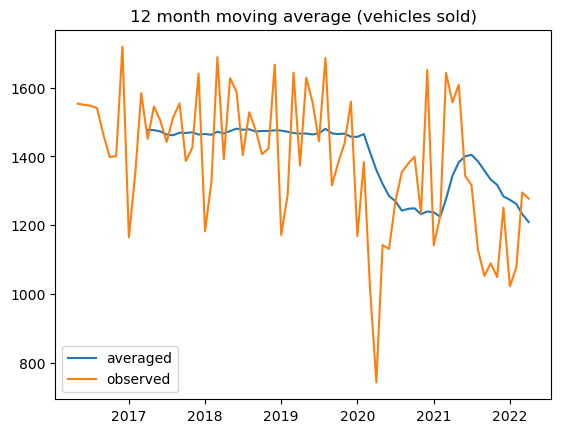

In [516]:
# displaying the 12 month moving average
plt.plot(df_last6years['TOTALNSA'].rolling(window=12).mean(), label = 'averaged') 
plt.plot(df_last6years['TOTALNSA'], label = 'observed') 
plt.legend()
plt.title('12 month moving average (vehicles sold)') 
plt.show() 

Let us remove the seasonality from the timeseries:

In [517]:
# store seasonal_decompose results in result (for the last 6 years)
result = seasonal_decompose(df_last6years['TOTALNSA'], model='multiplicative', period = 12)
# copy the last 6 years data into a new dataframe
df_last6years_ns = df_last6years.copy()
# subtract the seasonality from the original dataset
df_last6years_ns['TOTALNSA'] = df_last6years_ns['TOTALNSA'] - result.seasonal

Since our dataframe has a *DateTimeIndex*, we can use the *resample* method to summarise it in years. This makes the use of the *pct_change* pandas method very convenient to calculate the yearly percentage of change in vehicles sales:

In [518]:
# we use the same code we previously wrote, but on the data cleaned off the seasonality 
change_last5years_ns = (df_last6years_ns.resample('Y') # resample the data by year
                                  .mean() # calculate the mean (by year)
                                  .pct_change() # calculate the percentage of change
                                  [-5:]) # display the last 5 years

change_last5years_ns

,TOTALNSA
DATE,
2018-12-31,0.008413
2019-12-31,-0.012692
2020-12-31,-0.149163
2021-12-31,0.035456
2022-12-31,-0.090176


Similarly, we can work on the data smoothed with the rolling average:

In [519]:
# we create a dataframe containing the 12 month rolling average sales 
rolling_last5years_ns = pd.DataFrame(df_last6years_ns['TOTALNSA'].rolling(window=12).mean())

# # we use the same code we previously wrote, but on the data cleaned off the seasonality 
rolling_change_last5years_ns = (rolling_last5years_ns.resample('Y') # resample the data by year
              .mean() # calculate the mean (by year)
              .pct_change() # calculate the percentage of change
              [-5:]) # display the last 5 years

rolling_change_last5years_ns 

,TOTALNSA
DATE,
2018-12-31,0.002487
2019-12-31,-0.003371
2020-12-31,-0.104053
2021-12-31,0.010578
2022-12-31,-0.063795


Below we display and compare the observed and averaged sales, excluding the seasonality: 

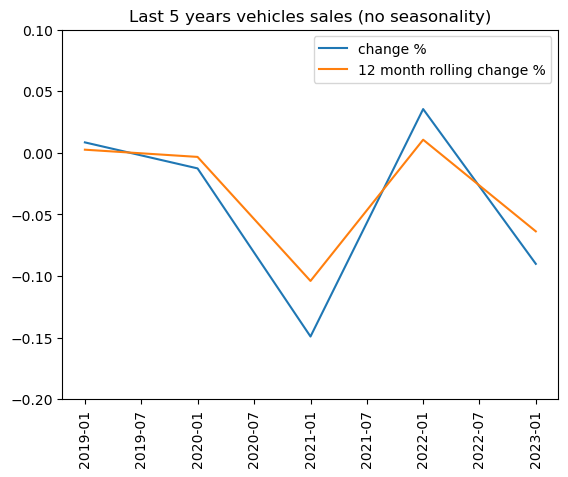

In [520]:
# displaying the 12 month moving average (no seasonality)
plt.plot(change_last5years_ns, label = 'change %') 
plt.plot(rolling_change_last5years_ns, label = '12 month rolling change %') 
plt.ylim(-0.2, 0.1)
plt.xticks(rotation=90)
plt.title('Last 5 years vehicles sales (no seasonality)') 
plt.legend()
plt.show() 

As presented by the tables and plots, vehicles sales over the last 5 years have shown a slightly negative trend. <br> Let us now perform a linear extrapolation, using the *statsmodel.interpolate* function, applied to SA vehicle sales, to forecast vehicle sales in 12 months time:   

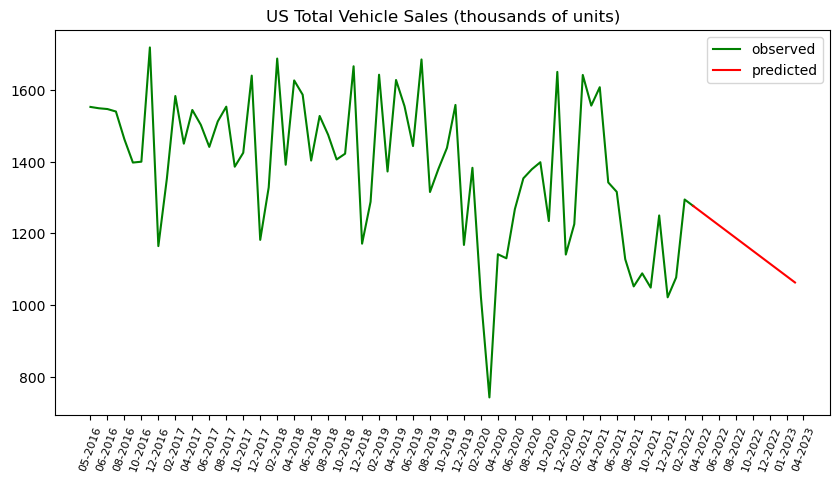

In [521]:
from scipy import interpolate
import datetime
# creates the range of dates to label the plot 
dates = pd.date_range(df_last6years_ns.index[0], df_last6years_ns.index[-1] + datetime.timedelta(days = 365),  periods=43).strftime('%m-%Y')

# set interpolation ranges
x = range(df_last6years_ns.shape[0]) 
x_extrap = range(x[-1], df_last6years_ns.shape[0]+12)

# interpolation
df_extr = interpolate.interp1d(x, df_last6years_ns['TOTALNSA'], fill_value='extrapolate')

# plot
fig, ax = plt.subplots(figsize=(10, 5)) 
plt.title('US Total Vehicle Sales (thousands of units)') 
plt.plot(df_last6years_ns['TOTALNSA'].to_numpy(), color = 'green', label = 'observed')
plt.plot(x_extrap, df_extr(x_extrap), color = 'red', label = 'predicted')
plt.xticks(ticks = range(0, 86, 2), labels = dates, rotation = 70, fontsize=8 )
plt.legend();

Our extrapolation (red line) identifies the negative trend and carries it out, in a linear fashion, for the next 12 months.  

## Exercise 3
Remove the trend from SA vehicles sales you calculated using differencing.
<br>
<br>
 Since the trend in our timeseries seems to be better modeled as linear (rather than exponential), we will *detrend* the data by *differencing*, using **subtraction**:

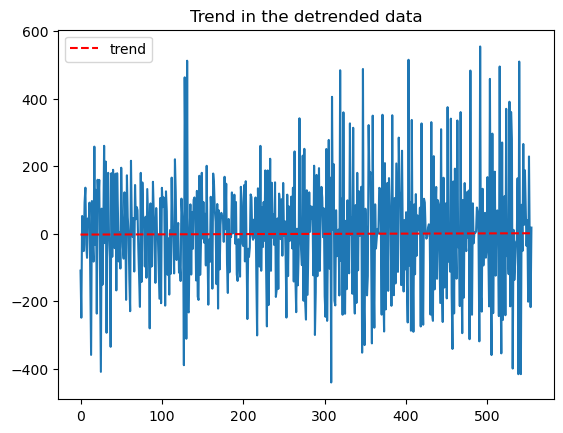

In [522]:
# index in the dataframe creating a 1 row (month) offset between the extracted values 
df_detrended = df[:-1].values - df[1:].values

# plot the detrended data
plt.plot(df_detrended)

# prepare and plot the trend line 
x = np.arange(0, len(df_detrended))
p1 = np.polyfit(x, np.array(df_detrended), 1)
p2 = np.poly1d(p1.reshape(2))
plt.plot(x, p2(x), "r--", label = 'trend')

plt.title('Trend in the detrended data')
plt.legend();

# Exercise 4
Use our auto_ARIMA function on the SA vehicles sales to forecast seasonally adjusted sales in 24 months time. <br>Also plot residuals of your model, and present statistics showing the goodness of fit. 

                            AutoReg Model Results                             
Dep. Variable:               TOTALNSA   No. Observations:                  545
Model:             Restr. AutoReg(12)   Log Likelihood               -3202.525
Method:               Conditional MLE   S.D. of innovations             98.450
Date:                Thu, 22 Sep 2022   AIC                           6411.050
Time:                        00:02:47   BIC                           6423.886
Sample:                    12-01-1977   HQIC                          6416.073
                         - 04-01-2022                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const          224.8967     31.133      7.224      0.000     163.877     285.916
TOTALNSA.L12     0.8246      0.024     33.768      0.000       0.777       0.872
                                    Roots   

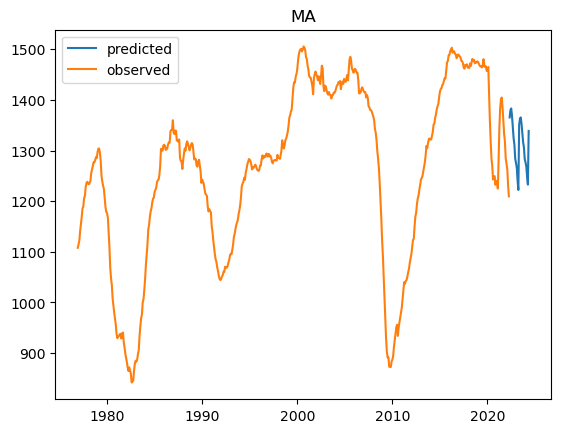

In [523]:
# hide warnings 
import warnings
warnings.filterwarnings('ignore')

#iomport the autoregression model
from statsmodels.tsa.ar_model import AutoReg

# AR model
df_sa = df.rolling(window=12).mean().dropna()
mod = AutoReg(df_sa, lags=[12]).fit()
print(mod.summary())

#Plot the predicted data
plt.plot(mod.predict(start = len(df_sa), end = len(df_sa) + 24, dynamic=False), label = 'predicted')
#Plot the orignial data
plt.plot(df_sa, label = 'observed')
plt.title('MA')
plt.legend()
plt.show()

Plot the model residuals and the statistics showing the goodness of fit:

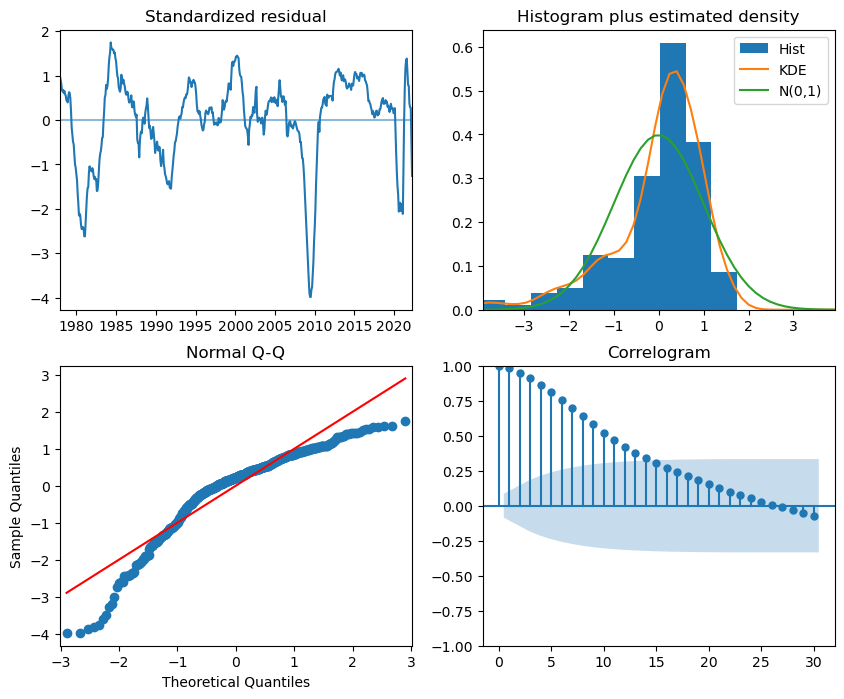

In [524]:
# plot the model diagnostics
fig = plt.figure(figsize=(10, 8))
fig = mod.plot_diagnostics(fig=fig, lags=30)